In [61]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [62]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [68]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.38,
 'Cell cooling surface area [m2]': 0.41,
 'Cell thermal expansion coefficient [m.K-1]': 1.48e-06,
 'Cell volume [m3]': 3.92e-05,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_Mohtat2020 at 0x00000121A2E3F430>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 5.0,
 'Electrode height [m]': 1.0,
 'Electrode width [m]': 0.1,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Siegel at 0x00000121A2E80700>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Siegel at 0x00000121A2E80820>,
 'Exchange-current density for plating [A.m-2]': <function plating_exchange_current_density_Mohtat2020 at 0x00000121A2E3F9D0>,
 'Excha

In [64]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

In [65]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
"Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
"Nominal cell capacity [A.h]":2.5,
"Maximum concentration in positive electrode [mol.m-3]":37500
        
    }
)

In [66]:
cell = 152002
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp=45


In [56]:
Created_Drive = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\Created_Drive_2_5Ah.csv", comment="#", header=None).to_numpy()


# pybamm.set_logging_level("WARNING")
experiment_Rest_steps = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Discharge at C/5 until 3.8V",
         "Hold at 3.8V for 2 hours",
         "Charge at C/5 until 4.2V", 
         "Hold at 4.2V for 4.8 hours"
        )

    ]*10,
    drive_cycles={"Creeted_Drive": Created_Drive},
    termination="60% capacity",
#     cccv_handling="ode",
)

eps_n_data

0.6234262178666925

In [67]:
eps_p_data

0.4483590386529399

In [57]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 8.3747149e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]": 9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]": 4.17385539e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 1.79830186e-18, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 6.18700763e+03, #1.87422275e+04,1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Lithium plating kinetic rate constant [m.s-1]": 4.50936e-10
    },
    check_already_exists=False,
)

In [58]:
pybamm.set_logging_level("NOTICE")

sim_long_Andrew_RestOnly = pybamm.Simulation(spm, experiment=experiment_Rest_steps, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_Andrew_RestOnly = sim_long_Andrew_RestOnly .solve(initial_soc=1, save_at_cycles=1  )

2023-02-17 10:11:21.319 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/10 (35.972 ms elapsed) --------------------
2023-02-17 10:11:21.326 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 1/4: Discharge at C/5 until 3.8V
2023-02-17 10:11:22.164 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 2/4: Hold at 3.8V for 2 hours
2023-02-17 10:11:23.218 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 3/4: Charge at C/5 until 4.2V
2023-02-17 10:11:23.691 - [NOTICE] callbacks.on_step_start(182): Cycle 1/10, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-17 10:11:26.082 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.501 Ah (originally 2.501 Ah, will stop at 1.501 Ah)
2023-02-17 10:11:26.082 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/10 (4.802 s elapsed) --------------------
2023-02-17 10:11:26.082 - [NOTICE] callbacks.on_step_start(182): Cycle 2/10, step 1/4: Discharge at C/5 until 3.8V
2023-02-17 10:11:26.322 - [NOTICE] callbacks.on_step_start(182):

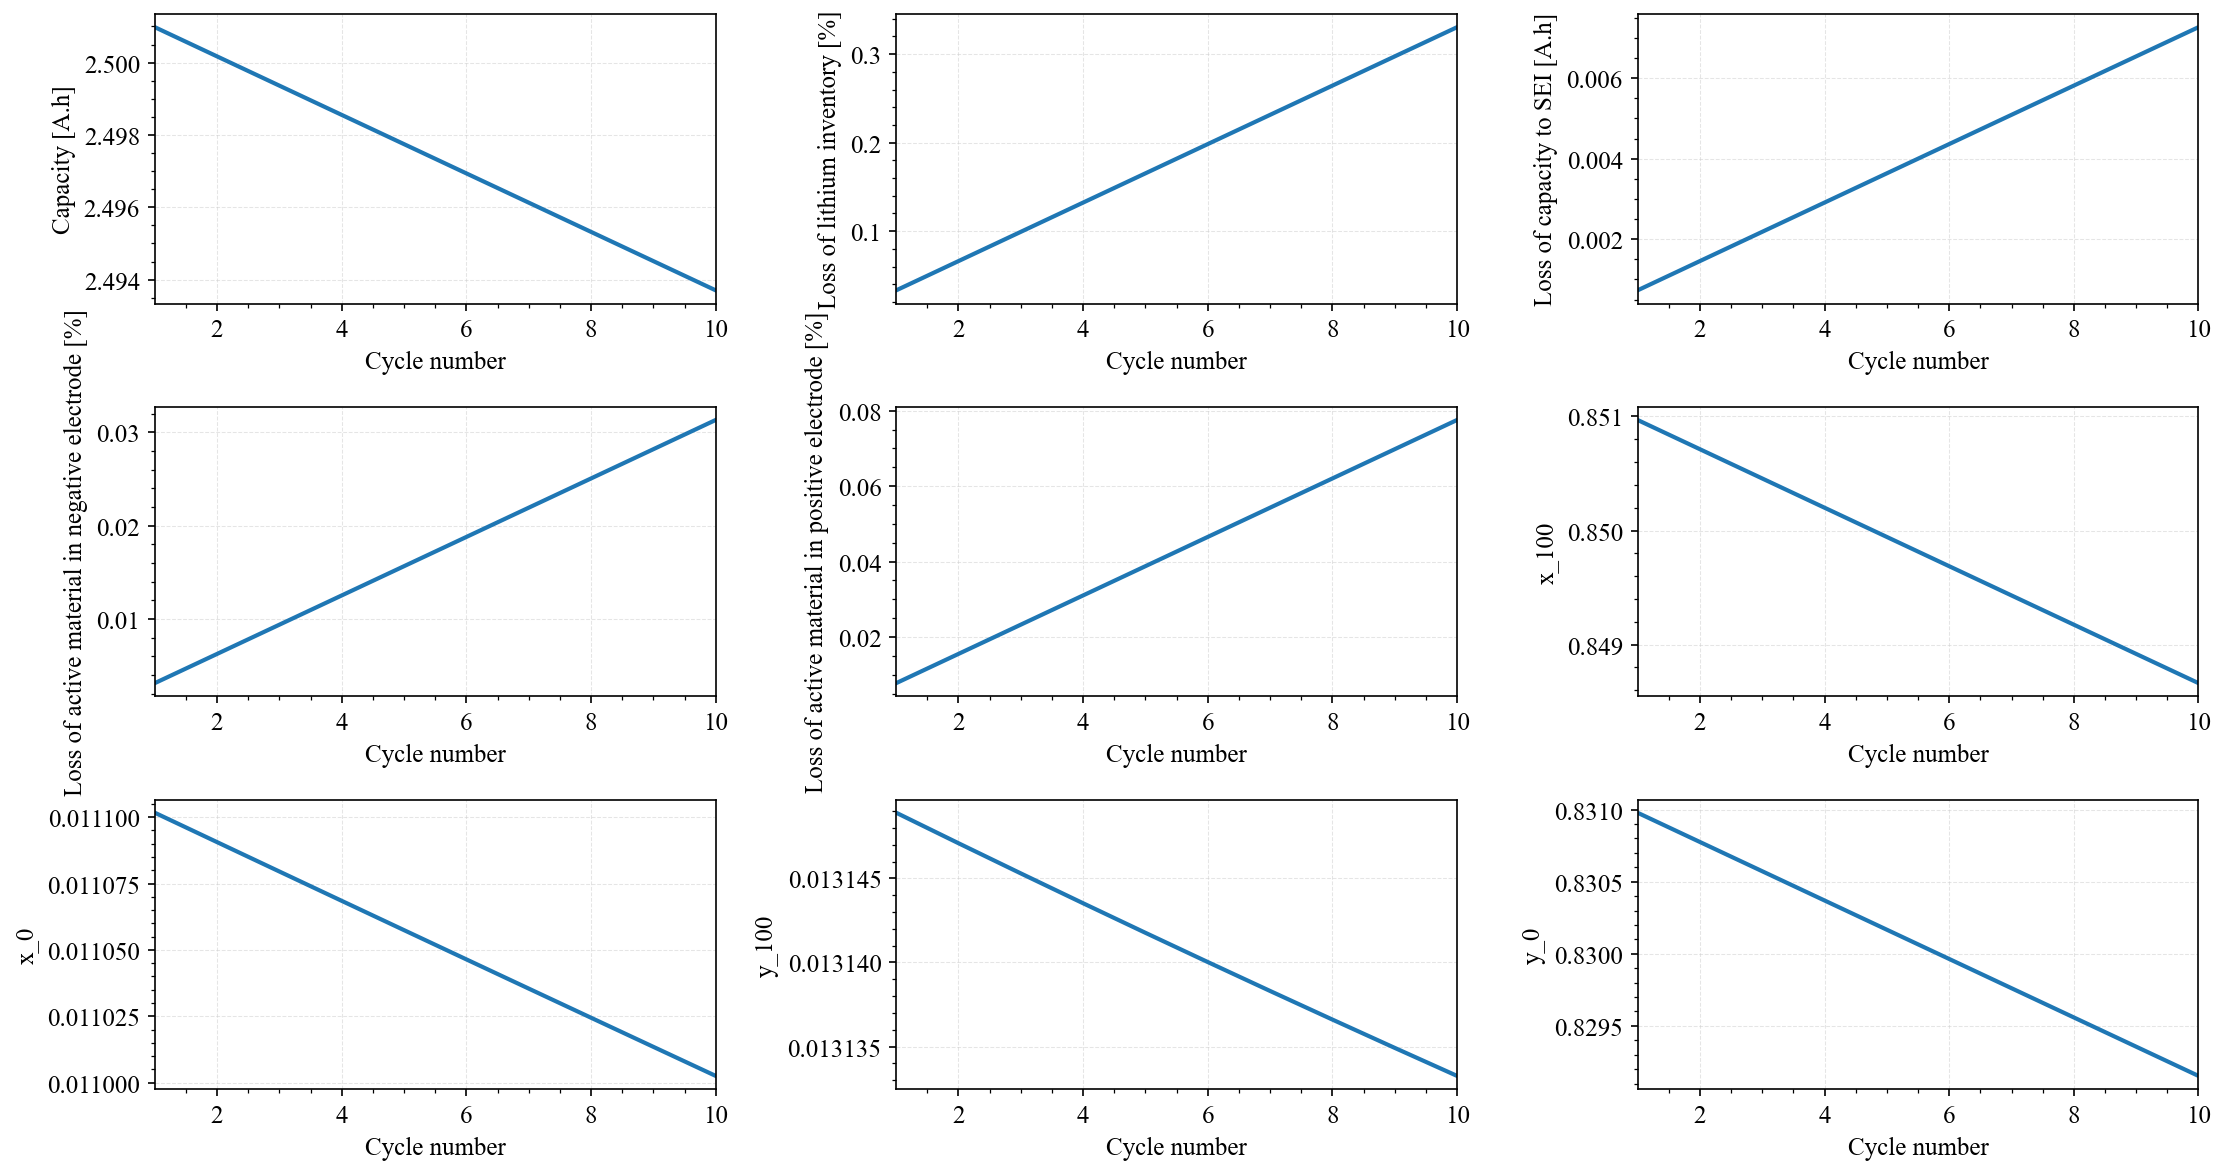

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [59]:
pybamm.plot_summary_variables(sol_long_Andrew_RestOnly)

In [60]:
sol_long_Andrew_RestOnly.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",

        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Throughput capacity [A.h]"



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=102.25454860509686, step=1.0225454860509686)…

In [ ]:
# ADdFEWF

In [14]:
parameter_values_peyman = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

parameter_values_peyman.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [15]:
spm_peyman = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

In [16]:
# spm.print_parameter_info()
param_peyman=spm_peyman.param
# parameter_values_peyman.update(
#     {
# "Electrode width [m]":0.205,
# #     "Maximum concentration in negative electrode [mol.m-3]":30000,
# "Nominal cell capacity [A.h]":2.5,
# "Maximum concentration in positive electrode [mol.m-3]":37500
        
#     }
# )
parameter_values_peyman.search("maximum")

Maximum concentration in negative electrode [mol.m-3]	28746.0
Maximum concentration in positive electrode [mol.m-3]	35380.0


In [17]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm_peyman,parameter_values_peyman)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp


25

In [18]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]


sno = 5


In [19]:





parameter_values_peyman.update(
    {
#         "Positive electrode LAM constant proportional term [s-1]":8.755e-8,   #2.5112e-07, #Using Sravan's new fit Dec27 2022
#         "Negative electrode LAM constant proportional term [s-1]":8.572e-7, #2.4741e-06,
#         "Positive electrode LAM constant exponential term":1.135, #1.1942,
#         "Negative electrode LAM constant exponential term":1.135,# 1.1942,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        
        "Upper voltage cut-off [V]":4.2,
        "SEI resistivity [Ohm.m]":30000.0
        
        
    },
    check_already_exists=False,
)

In [20]:
# # pybamm.set_logging_level("WARNING")
# experiment_Rest_steps = pybamm.Experiment( #Created_ DRC-DRC
#     [
#         ("Discharge at C/5 until 3.8V",
#          "Hold at 3.8V for 2 hours",
#          "Charge at C/5 until 4.2V", 
#          "Hold at 4.2V for 4.8 hours"
#         )

#     ]*500,
#     drive_cycles={"Creeted_Drive": Created_Drive},
#     termination="60% capacity",
# #     cccv_handling="ode",
# )

eps_n_data

0.6234262178666925

In [21]:



sim_long_peyman_RestOnly = pybamm.Simulation(spm_peyman, experiment=experiment_Rest_steps, parameter_values=parameter_values_peyman, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_peyman_ResytOnly = sim_long_peyman_RestOnly .solve(initial_soc=1, save_at_cycles=20  )

2023-02-16 14:35:42.892 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/500 (19.798 ms elapsed) --------------------
2023-02-16 14:35:42.893 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:35:43.241 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:35:44.053 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:35:44.415 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:35:46.515 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.069 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:35:46.515 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/500 (3.652 s elapsed) --------------------
2023-02-16 14:35:46.525 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:35:46.742 - [NOTICE] callbacks.on_step_star

2023-02-16 14:36:15.125 - [NOTICE] callbacks.on_step_start(182): Cycle 12/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:36:16.710 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.053 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:36:16.720 - [NOTICE] callbacks.on_cycle_start(174): Cycle 13/500 (33.848 s elapsed) --------------------
2023-02-16 14:36:16.720 - [NOTICE] callbacks.on_step_start(182): Cycle 13/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:36:16.945 - [NOTICE] callbacks.on_step_start(182): Cycle 13/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:36:17.577 - [NOTICE] callbacks.on_step_start(182): Cycle 13/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:36:17.800 - [NOTICE] callbacks.on_step_start(182): Cycle 13/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:36:19.363 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.052 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:36:19.364 - [NOTICE] c

2023-02-16 14:36:45.670 - [NOTICE] callbacks.on_step_start(182): Cycle 24/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:36:45.892 - [NOTICE] callbacks.on_step_start(182): Cycle 24/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:36:46.519 - [NOTICE] callbacks.on_step_start(182): Cycle 24/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:36:46.729 - [NOTICE] callbacks.on_step_start(182): Cycle 24/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:36:48.298 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.036 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:36:48.298 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/500 (1 minute, 5 seconds elapsed) --------------------
2023-02-16 14:36:48.298 - [NOTICE] callbacks.on_step_start(182): Cycle 25/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:36:48.512 - [NOTICE] callbacks.on_step_start(182): Cycle 25/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:36:49.146 - [NOTICE] callbacks

2023-02-16 14:37:15.881 - [NOTICE] callbacks.on_step_start(182): Cycle 35/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:37:16.094 - [NOTICE] callbacks.on_step_start(182): Cycle 35/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:37:17.659 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.020 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:37:17.660 - [NOTICE] callbacks.on_cycle_start(174): Cycle 36/500 (1 minute, 35 seconds elapsed) --------------------
2023-02-16 14:37:17.661 - [NOTICE] callbacks.on_step_start(182): Cycle 36/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:37:17.877 - [NOTICE] callbacks.on_step_start(182): Cycle 36/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:37:18.502 - [NOTICE] callbacks.on_step_start(182): Cycle 36/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:37:18.715 - [NOTICE] callbacks.on_step_start(182): Cycle 36/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:37:20.261 - [NOTICE] callbacks

2023-02-16 14:37:48.232 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.004 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:37:48.232 - [NOTICE] callbacks.on_cycle_start(174): Cycle 47/500 (2 minutes, 5 seconds elapsed) --------------------
2023-02-16 14:37:48.232 - [NOTICE] callbacks.on_step_start(182): Cycle 47/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:37:48.452 - [NOTICE] callbacks.on_step_start(182): Cycle 47/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:37:49.144 - [NOTICE] callbacks.on_step_start(182): Cycle 47/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:37:49.382 - [NOTICE] callbacks.on_step_start(182): Cycle 47/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:37:51.004 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.002 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:37:51.005 - [NOTICE] callbacks.on_cycle_start(174): Cycle 48/500 (2 minutes, 8 seconds elapsed) --------------------
2023-02-1

2023-02-16 14:38:18.253 - [NOTICE] callbacks.on_step_start(182): Cycle 58/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:38:18.473 - [NOTICE] callbacks.on_step_start(182): Cycle 58/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:38:19.085 - [NOTICE] callbacks.on_step_start(182): Cycle 58/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:38:19.316 - [NOTICE] callbacks.on_step_start(182): Cycle 58/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:38:20.928 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.986 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:38:20.928 - [NOTICE] callbacks.on_cycle_start(174): Cycle 59/500 (2 minutes, 38 seconds elapsed) --------------------
2023-02-16 14:38:20.938 - [NOTICE] callbacks.on_step_start(182): Cycle 59/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:38:21.148 - [NOTICE] callbacks.on_step_start(182): Cycle 59/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:38:21.769 - [NOTICE] callbac

2023-02-16 14:38:49.473 - [NOTICE] callbacks.on_step_start(182): Cycle 69/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:38:49.704 - [NOTICE] callbacks.on_step_start(182): Cycle 69/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:38:51.262 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.969 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:38:51.262 - [NOTICE] callbacks.on_cycle_start(174): Cycle 70/500 (3 minutes, 8 seconds elapsed) --------------------
2023-02-16 14:38:51.262 - [NOTICE] callbacks.on_step_start(182): Cycle 70/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:38:51.486 - [NOTICE] callbacks.on_step_start(182): Cycle 70/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:38:52.117 - [NOTICE] callbacks.on_step_start(182): Cycle 70/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:38:52.336 - [NOTICE] callbacks.on_step_start(182): Cycle 70/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:38:53.883 - [NOTICE] callbacks

2023-02-16 14:39:20.658 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.953 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:39:20.658 - [NOTICE] callbacks.on_cycle_start(174): Cycle 81/500 (3 minutes, 38 seconds elapsed) --------------------
2023-02-16 14:39:20.658 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:39:20.884 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:39:21.524 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:39:21.788 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:39:23.333 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.951 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:39:23.333 - [NOTICE] callbacks.on_cycle_start(174): Cycle 82/500 (3 minutes, 40 seconds elapsed) --------------------
2023-02

2023-02-16 14:39:49.952 - [NOTICE] callbacks.on_step_start(182): Cycle 92/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:39:50.165 - [NOTICE] callbacks.on_step_start(182): Cycle 92/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:39:50.781 - [NOTICE] callbacks.on_step_start(182): Cycle 92/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:39:50.999 - [NOTICE] callbacks.on_step_start(182): Cycle 92/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:39:52.539 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.934 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:39:52.539 - [NOTICE] callbacks.on_cycle_start(174): Cycle 93/500 (4 minutes, 10 seconds elapsed) --------------------
2023-02-16 14:39:52.539 - [NOTICE] callbacks.on_step_start(182): Cycle 93/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:39:52.768 - [NOTICE] callbacks.on_step_start(182): Cycle 93/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:39:53.382 - [NOTICE] callbac

2023-02-16 14:40:20.164 - [NOTICE] callbacks.on_step_start(182): Cycle 103/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:40:20.377 - [NOTICE] callbacks.on_step_start(182): Cycle 103/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:40:21.947 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.917 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:40:21.947 - [NOTICE] callbacks.on_cycle_start(174): Cycle 104/500 (4 minutes, 39 seconds elapsed) --------------------
2023-02-16 14:40:21.947 - [NOTICE] callbacks.on_step_start(182): Cycle 104/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:40:22.170 - [NOTICE] callbacks.on_step_start(182): Cycle 104/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:40:22.811 - [NOTICE] callbacks.on_step_start(182): Cycle 104/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:40:23.037 - [NOTICE] callbacks.on_step_start(182): Cycle 104/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:40:24.867 - [NOTICE] c

2023-02-16 14:40:51.774 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.900 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:40:51.774 - [NOTICE] callbacks.on_cycle_start(174): Cycle 115/500 (5 minutes, 9 seconds elapsed) --------------------
2023-02-16 14:40:51.774 - [NOTICE] callbacks.on_step_start(182): Cycle 115/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:40:52.003 - [NOTICE] callbacks.on_step_start(182): Cycle 115/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:40:52.615 - [NOTICE] callbacks.on_step_start(182): Cycle 115/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:40:52.825 - [NOTICE] callbacks.on_step_start(182): Cycle 115/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:40:54.397 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.899 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:40:54.397 - [NOTICE] callbacks.on_cycle_start(174): Cycle 116/500 (5 minutes, 12 seconds elapsed) --------------------
20

2023-02-16 14:41:20.548 - [NOTICE] callbacks.on_step_start(182): Cycle 126/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:41:20.752 - [NOTICE] callbacks.on_step_start(182): Cycle 126/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:41:21.371 - [NOTICE] callbacks.on_step_start(182): Cycle 126/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:41:21.582 - [NOTICE] callbacks.on_step_start(182): Cycle 126/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:41:23.204 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.882 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:41:23.204 - [NOTICE] callbacks.on_cycle_start(174): Cycle 127/500 (5 minutes, 40 seconds elapsed) --------------------
2023-02-16 14:41:23.204 - [NOTICE] callbacks.on_step_start(182): Cycle 127/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:41:23.416 - [NOTICE] callbacks.on_step_start(182): Cycle 127/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:41:24.043 - [NOTICE] 

2023-02-16 14:41:50.662 - [NOTICE] callbacks.on_step_start(182): Cycle 137/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:41:50.860 - [NOTICE] callbacks.on_step_start(182): Cycle 137/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:41:52.416 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.865 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:41:52.416 - [NOTICE] callbacks.on_cycle_start(174): Cycle 138/500 (6 minutes, 10 seconds elapsed) --------------------
2023-02-16 14:41:52.416 - [NOTICE] callbacks.on_step_start(182): Cycle 138/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:41:52.622 - [NOTICE] callbacks.on_step_start(182): Cycle 138/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:41:53.243 - [NOTICE] callbacks.on_step_start(182): Cycle 138/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:41:53.454 - [NOTICE] callbacks.on_step_start(182): Cycle 138/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:41:54.995 - [NOTICE] c

2023-02-16 14:42:20.944 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.848 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:42:20.945 - [NOTICE] callbacks.on_cycle_start(174): Cycle 149/500 (6 minutes, 38 seconds elapsed) --------------------
2023-02-16 14:42:20.946 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:42:21.138 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:42:21.763 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:42:21.954 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:42:23.497 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.847 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:42:23.497 - [NOTICE] callbacks.on_cycle_start(174): Cycle 150/500 (6 minutes, 41 seconds elapsed) --------------------
2

2023-02-16 14:42:49.216 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:42:49.416 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:42:50.023 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:42:50.212 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:42:51.769 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.830 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:42:51.769 - [NOTICE] callbacks.on_cycle_start(174): Cycle 161/500 (7 minutes, 9 seconds elapsed) --------------------
2023-02-16 14:42:51.769 - [NOTICE] callbacks.on_step_start(182): Cycle 161/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:42:51.971 - [NOTICE] callbacks.on_step_start(182): Cycle 161/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:42:52.585 - [NOTICE] c

2023-02-16 14:43:18.828 - [NOTICE] callbacks.on_step_start(182): Cycle 171/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:43:19.019 - [NOTICE] callbacks.on_step_start(182): Cycle 171/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:43:20.562 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.813 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:43:20.562 - [NOTICE] callbacks.on_cycle_start(174): Cycle 172/500 (7 minutes, 38 seconds elapsed) --------------------
2023-02-16 14:43:20.562 - [NOTICE] callbacks.on_step_start(182): Cycle 172/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:43:20.765 - [NOTICE] callbacks.on_step_start(182): Cycle 172/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:43:21.385 - [NOTICE] callbacks.on_step_start(182): Cycle 172/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:43:21.578 - [NOTICE] callbacks.on_step_start(182): Cycle 172/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:43:23.149 - [NOTICE] c

2023-02-16 14:43:48.869 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.796 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:43:48.869 - [NOTICE] callbacks.on_cycle_start(174): Cycle 183/500 (8 minutes, 6 seconds elapsed) --------------------
2023-02-16 14:43:48.869 - [NOTICE] callbacks.on_step_start(182): Cycle 183/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:43:49.078 - [NOTICE] callbacks.on_step_start(182): Cycle 183/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:43:49.697 - [NOTICE] callbacks.on_step_start(182): Cycle 183/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:43:49.884 - [NOTICE] callbacks.on_step_start(182): Cycle 183/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:43:51.429 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.794 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:43:51.430 - [NOTICE] callbacks.on_cycle_start(174): Cycle 184/500 (8 minutes, 9 seconds elapsed) --------------------
202

2023-02-16 14:44:17.676 - [NOTICE] callbacks.on_step_start(182): Cycle 194/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:44:17.874 - [NOTICE] callbacks.on_step_start(182): Cycle 194/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:44:18.495 - [NOTICE] callbacks.on_step_start(182): Cycle 194/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:44:18.692 - [NOTICE] callbacks.on_step_start(182): Cycle 194/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:44:20.253 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.778 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:44:20.253 - [NOTICE] callbacks.on_cycle_start(174): Cycle 195/500 (8 minutes, 37 seconds elapsed) --------------------
2023-02-16 14:44:20.253 - [NOTICE] callbacks.on_step_start(182): Cycle 195/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:44:20.454 - [NOTICE] callbacks.on_step_start(182): Cycle 195/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:44:21.053 - [NOTICE] 

2023-02-16 14:44:47.416 - [NOTICE] callbacks.on_step_start(182): Cycle 205/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:44:47.608 - [NOTICE] callbacks.on_step_start(182): Cycle 205/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:44:49.162 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.761 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:44:49.164 - [NOTICE] callbacks.on_cycle_start(174): Cycle 206/500 (9 minutes, 6 seconds elapsed) --------------------
2023-02-16 14:44:49.165 - [NOTICE] callbacks.on_step_start(182): Cycle 206/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:44:49.349 - [NOTICE] callbacks.on_step_start(182): Cycle 206/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:44:49.971 - [NOTICE] callbacks.on_step_start(182): Cycle 206/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:44:50.164 - [NOTICE] callbacks.on_step_start(182): Cycle 206/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:44:51.704 - [NOTICE] ca

2023-02-16 14:45:17.906 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.744 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:45:17.906 - [NOTICE] callbacks.on_cycle_start(174): Cycle 217/500 (9 minutes, 35 seconds elapsed) --------------------
2023-02-16 14:45:17.906 - [NOTICE] callbacks.on_step_start(182): Cycle 217/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:45:18.117 - [NOTICE] callbacks.on_step_start(182): Cycle 217/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:45:18.721 - [NOTICE] callbacks.on_step_start(182): Cycle 217/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:45:18.903 - [NOTICE] callbacks.on_step_start(182): Cycle 217/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:45:20.476 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.743 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:45:20.476 - [NOTICE] callbacks.on_cycle_start(174): Cycle 218/500 (9 minutes, 38 seconds elapsed) --------------------
2

2023-02-16 14:45:46.175 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:45:46.375 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:45:46.993 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:45:47.188 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:45:48.747 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.726 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:45:48.747 - [NOTICE] callbacks.on_cycle_start(174): Cycle 229/500 (10 minutes, 6 seconds elapsed) --------------------
2023-02-16 14:45:48.747 - [NOTICE] callbacks.on_step_start(182): Cycle 229/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:45:48.947 - [NOTICE] callbacks.on_step_start(182): Cycle 229/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:45:49.564 - [NOTICE] 

2023-02-16 14:46:15.101 - [NOTICE] callbacks.on_step_start(182): Cycle 239/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:46:15.316 - [NOTICE] callbacks.on_step_start(182): Cycle 239/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:46:16.879 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.709 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:46:16.880 - [NOTICE] callbacks.on_cycle_start(174): Cycle 240/500 (10 minutes, 34 seconds elapsed) --------------------
2023-02-16 14:46:16.881 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:46:17.066 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:46:17.685 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:46:17.882 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:46:19.430 - [NOTICE] 

2023-02-16 14:46:45.518 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.693 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:46:45.519 - [NOTICE] callbacks.on_cycle_start(174): Cycle 251/500 (11 minutes, 3 seconds elapsed) --------------------
2023-02-16 14:46:45.520 - [NOTICE] callbacks.on_step_start(182): Cycle 251/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:46:45.722 - [NOTICE] callbacks.on_step_start(182): Cycle 251/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:46:46.327 - [NOTICE] callbacks.on_step_start(182): Cycle 251/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:46:46.513 - [NOTICE] callbacks.on_step_start(182): Cycle 251/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:46:48.055 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.691 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:46:48.055 - [NOTICE] callbacks.on_cycle_start(174): Cycle 252/500 (11 minutes, 5 seconds elapsed) --------------------
2

2023-02-16 14:47:13.493 - [NOTICE] callbacks.on_cycle_start(174): Cycle 262/500 (11 minutes, 31 seconds elapsed) --------------------
2023-02-16 14:47:13.493 - [NOTICE] callbacks.on_step_start(182): Cycle 262/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:47:13.721 - [NOTICE] callbacks.on_step_start(182): Cycle 262/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:47:14.371 - [NOTICE] callbacks.on_step_start(182): Cycle 262/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:47:14.560 - [NOTICE] callbacks.on_step_start(182): Cycle 262/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:47:16.159 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.675 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:47:16.159 - [NOTICE] callbacks.on_cycle_start(174): Cycle 263/500 (11 minutes, 33 seconds elapsed) --------------------
2023-02-16 14:47:16.159 - [NOTICE] callbacks.on_step_start(182): Cycle 263/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:4

2023-02-16 14:47:42.678 - [NOTICE] callbacks.on_step_start(182): Cycle 273/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:47:42.879 - [NOTICE] callbacks.on_step_start(182): Cycle 273/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:47:43.484 - [NOTICE] callbacks.on_step_start(182): Cycle 273/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:47:43.679 - [NOTICE] callbacks.on_step_start(182): Cycle 273/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:47:45.231 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.658 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:47:45.231 - [NOTICE] callbacks.on_cycle_start(174): Cycle 274/500 (12 minutes, 2 seconds elapsed) --------------------
2023-02-16 14:47:45.231 - [NOTICE] callbacks.on_step_start(182): Cycle 274/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:47:45.428 - [NOTICE] callbacks.on_step_start(182): Cycle 274/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:47:46.039 - [NOTICE] 

2023-02-16 14:48:11.614 - [NOTICE] callbacks.on_step_start(182): Cycle 284/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:48:11.800 - [NOTICE] callbacks.on_step_start(182): Cycle 284/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:48:13.339 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.642 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:48:13.339 - [NOTICE] callbacks.on_cycle_start(174): Cycle 285/500 (12 minutes, 30 seconds elapsed) --------------------
2023-02-16 14:48:13.339 - [NOTICE] callbacks.on_step_start(182): Cycle 285/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:48:13.536 - [NOTICE] callbacks.on_step_start(182): Cycle 285/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:48:14.158 - [NOTICE] callbacks.on_step_start(182): Cycle 285/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:48:14.347 - [NOTICE] callbacks.on_step_start(182): Cycle 285/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:48:15.914 - [NOTICE] 

2023-02-16 14:48:41.493 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.625 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:48:41.493 - [NOTICE] callbacks.on_cycle_start(174): Cycle 296/500 (12 minutes, 59 seconds elapsed) --------------------
2023-02-16 14:48:41.493 - [NOTICE] callbacks.on_step_start(182): Cycle 296/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:48:41.685 - [NOTICE] callbacks.on_step_start(182): Cycle 296/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:48:42.314 - [NOTICE] callbacks.on_step_start(182): Cycle 296/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:48:42.493 - [NOTICE] callbacks.on_step_start(182): Cycle 296/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:48:44.062 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.624 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:48:44.072 - [NOTICE] callbacks.on_cycle_start(174): Cycle 297/500 (13 minutes, 1 second elapsed) --------------------
2

2023-02-16 14:49:10.109 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:49:10.350 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:49:10.965 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:49:11.148 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:49:12.690 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.607 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:49:12.690 - [NOTICE] callbacks.on_cycle_start(174): Cycle 308/500 (13 minutes, 30 seconds elapsed) --------------------
2023-02-16 14:49:12.690 - [NOTICE] callbacks.on_step_start(182): Cycle 308/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:49:12.879 - [NOTICE] callbacks.on_step_start(182): Cycle 308/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:49:13.491 - [NOTICE]

2023-02-16 14:49:39.074 - [NOTICE] callbacks.on_step_start(182): Cycle 318/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:49:39.259 - [NOTICE] callbacks.on_step_start(182): Cycle 318/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:49:40.796 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.591 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:49:40.796 - [NOTICE] callbacks.on_cycle_start(174): Cycle 319/500 (13 minutes, 58 seconds elapsed) --------------------
2023-02-16 14:49:40.796 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:49:40.986 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:49:41.590 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:49:41.781 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:49:43.328 - [NOTICE] 

2023-02-16 14:50:09.356 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.574 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:50:09.356 - [NOTICE] callbacks.on_cycle_start(174): Cycle 330/500 (14 minutes, 26 seconds elapsed) --------------------
2023-02-16 14:50:09.356 - [NOTICE] callbacks.on_step_start(182): Cycle 330/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:50:09.555 - [NOTICE] callbacks.on_step_start(182): Cycle 330/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:50:10.165 - [NOTICE] callbacks.on_step_start(182): Cycle 330/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:50:10.356 - [NOTICE] callbacks.on_step_start(182): Cycle 330/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:50:11.889 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.573 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:50:11.889 - [NOTICE] callbacks.on_cycle_start(174): Cycle 331/500 (14 minutes, 29 seconds elapsed) --------------------

2023-02-16 14:50:37.415 - [NOTICE] callbacks.on_cycle_start(174): Cycle 341/500 (14 minutes, 55 seconds elapsed) --------------------
2023-02-16 14:50:37.415 - [NOTICE] callbacks.on_step_start(182): Cycle 341/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:50:37.606 - [NOTICE] callbacks.on_step_start(182): Cycle 341/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:50:38.227 - [NOTICE] callbacks.on_step_start(182): Cycle 341/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:50:38.404 - [NOTICE] callbacks.on_step_start(182): Cycle 341/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:50:39.951 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.557 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:50:39.952 - [NOTICE] callbacks.on_cycle_start(174): Cycle 342/500 (14 minutes, 57 seconds elapsed) --------------------
2023-02-16 14:50:39.952 - [NOTICE] callbacks.on_step_start(182): Cycle 342/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:5

2023-02-16 14:51:05.668 - [NOTICE] callbacks.on_step_start(182): Cycle 352/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:51:05.870 - [NOTICE] callbacks.on_step_start(182): Cycle 352/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:51:06.579 - [NOTICE] callbacks.on_step_start(182): Cycle 352/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:51:06.785 - [NOTICE] callbacks.on_step_start(182): Cycle 352/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:51:08.415 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.540 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:51:08.416 - [NOTICE] callbacks.on_cycle_start(174): Cycle 353/500 (15 minutes, 26 seconds elapsed) --------------------
2023-02-16 14:51:08.417 - [NOTICE] callbacks.on_step_start(182): Cycle 353/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:51:08.669 - [NOTICE] callbacks.on_step_start(182): Cycle 353/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:51:09.298 - [NOTICE]

2023-02-16 14:51:35.684 - [NOTICE] callbacks.on_step_start(182): Cycle 363/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:51:35.860 - [NOTICE] callbacks.on_step_start(182): Cycle 363/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:51:37.415 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.524 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:51:37.415 - [NOTICE] callbacks.on_cycle_start(174): Cycle 364/500 (15 minutes, 55 seconds elapsed) --------------------
2023-02-16 14:51:37.425 - [NOTICE] callbacks.on_step_start(182): Cycle 364/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:51:37.618 - [NOTICE] callbacks.on_step_start(182): Cycle 364/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:51:38.226 - [NOTICE] callbacks.on_step_start(182): Cycle 364/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:51:38.422 - [NOTICE] callbacks.on_step_start(182): Cycle 364/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:51:39.950 - [NOTICE] 

2023-02-16 14:52:06.127 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.508 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:52:06.127 - [NOTICE] callbacks.on_cycle_start(174): Cycle 375/500 (16 minutes, 23 seconds elapsed) --------------------
2023-02-16 14:52:06.127 - [NOTICE] callbacks.on_step_start(182): Cycle 375/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:52:06.313 - [NOTICE] callbacks.on_step_start(182): Cycle 375/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:52:06.924 - [NOTICE] callbacks.on_step_start(182): Cycle 375/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:52:07.108 - [NOTICE] callbacks.on_step_start(182): Cycle 375/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:52:08.692 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.506 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:52:08.692 - [NOTICE] callbacks.on_cycle_start(174): Cycle 376/500 (16 minutes, 26 seconds elapsed) --------------------

2023-02-16 14:52:34.589 - [NOTICE] callbacks.on_cycle_start(174): Cycle 386/500 (16 minutes, 52 seconds elapsed) --------------------
2023-02-16 14:52:34.589 - [NOTICE] callbacks.on_step_start(182): Cycle 386/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:52:34.806 - [NOTICE] callbacks.on_step_start(182): Cycle 386/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:52:35.484 - [NOTICE] callbacks.on_step_start(182): Cycle 386/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:52:35.663 - [NOTICE] callbacks.on_step_start(182): Cycle 386/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:52:37.296 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.490 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:52:37.296 - [NOTICE] callbacks.on_cycle_start(174): Cycle 387/500 (16 minutes, 54 seconds elapsed) --------------------
2023-02-16 14:52:37.296 - [NOTICE] callbacks.on_step_start(182): Cycle 387/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:5

2023-02-16 14:53:04.592 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:53:04.774 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:53:05.392 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:53:05.570 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:53:07.138 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.474 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:53:07.138 - [NOTICE] callbacks.on_cycle_start(174): Cycle 398/500 (17 minutes, 24 seconds elapsed) --------------------
2023-02-16 14:53:07.138 - [NOTICE] callbacks.on_step_start(182): Cycle 398/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:53:07.333 - [NOTICE] callbacks.on_step_start(182): Cycle 398/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:53:07.941 - [NOTICE]

2023-02-16 14:53:34.609 - [NOTICE] callbacks.on_step_start(182): Cycle 408/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:53:34.817 - [NOTICE] callbacks.on_step_start(182): Cycle 408/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:53:36.410 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.458 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:53:36.410 - [NOTICE] callbacks.on_cycle_start(174): Cycle 409/500 (17 minutes, 54 seconds elapsed) --------------------
2023-02-16 14:53:36.410 - [NOTICE] callbacks.on_step_start(182): Cycle 409/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:53:36.600 - [NOTICE] callbacks.on_step_start(182): Cycle 409/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:53:37.254 - [NOTICE] callbacks.on_step_start(182): Cycle 409/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:53:37.450 - [NOTICE] callbacks.on_step_start(182): Cycle 409/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:53:39.040 - [NOTICE] 

2023-02-16 14:54:05.095 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.442 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:54:05.104 - [NOTICE] callbacks.on_cycle_start(174): Cycle 420/500 (18 minutes, 22 seconds elapsed) --------------------
2023-02-16 14:54:05.104 - [NOTICE] callbacks.on_step_start(182): Cycle 420/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:54:05.307 - [NOTICE] callbacks.on_step_start(182): Cycle 420/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:54:06.033 - [NOTICE] callbacks.on_step_start(182): Cycle 420/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:54:06.235 - [NOTICE] callbacks.on_step_start(182): Cycle 420/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:54:07.983 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.440 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:54:07.984 - [NOTICE] callbacks.on_cycle_start(174): Cycle 421/500 (18 minutes, 25 seconds elapsed) --------------------

2023-02-16 14:54:39.829 - [NOTICE] callbacks.on_cycle_start(174): Cycle 431/500 (18 minutes, 57 seconds elapsed) --------------------
2023-02-16 14:54:39.830 - [NOTICE] callbacks.on_step_start(182): Cycle 431/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:54:40.006 - [NOTICE] callbacks.on_step_start(182): Cycle 431/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:54:40.638 - [NOTICE] callbacks.on_step_start(182): Cycle 431/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:54:40.820 - [NOTICE] callbacks.on_step_start(182): Cycle 431/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:54:42.388 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.424 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:54:42.388 - [NOTICE] callbacks.on_cycle_start(174): Cycle 432/500 (19 minutes, 0 seconds elapsed) --------------------
2023-02-16 14:54:42.388 - [NOTICE] callbacks.on_step_start(182): Cycle 432/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:54

2023-02-16 14:55:12.869 - [NOTICE] callbacks.on_step_start(182): Cycle 442/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:55:13.064 - [NOTICE] callbacks.on_step_start(182): Cycle 442/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:55:13.714 - [NOTICE] callbacks.on_step_start(182): Cycle 442/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:55:13.906 - [NOTICE] callbacks.on_step_start(182): Cycle 442/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:55:15.634 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.408 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:55:15.634 - [NOTICE] callbacks.on_cycle_start(174): Cycle 443/500 (19 minutes, 33 seconds elapsed) --------------------
2023-02-16 14:55:15.634 - [NOTICE] callbacks.on_step_start(182): Cycle 443/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:55:15.858 - [NOTICE] callbacks.on_step_start(182): Cycle 443/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:55:16.572 - [NOTICE]

2023-02-16 14:55:46.497 - [NOTICE] callbacks.on_step_start(182): Cycle 453/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:55:46.702 - [NOTICE] callbacks.on_step_start(182): Cycle 453/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:55:48.306 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.392 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:55:48.306 - [NOTICE] callbacks.on_cycle_start(174): Cycle 454/500 (20 minutes, 5 seconds elapsed) --------------------
2023-02-16 14:55:48.306 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:55:48.488 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:55:49.111 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:55:49.302 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:55:50.867 - [NOTICE] c

2023-02-16 14:56:17.213 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.376 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:56:17.213 - [NOTICE] callbacks.on_cycle_start(174): Cycle 465/500 (20 minutes, 34 seconds elapsed) --------------------
2023-02-16 14:56:17.213 - [NOTICE] callbacks.on_step_start(182): Cycle 465/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:56:17.396 - [NOTICE] callbacks.on_step_start(182): Cycle 465/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:56:18.017 - [NOTICE] callbacks.on_step_start(182): Cycle 465/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:56:18.210 - [NOTICE] callbacks.on_step_start(182): Cycle 465/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:56:19.775 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.374 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:56:19.775 - [NOTICE] callbacks.on_cycle_start(174): Cycle 466/500 (20 minutes, 37 seconds elapsed) --------------------

2023-02-16 14:56:45.791 - [NOTICE] callbacks.on_cycle_start(174): Cycle 476/500 (21 minutes, 3 seconds elapsed) --------------------
2023-02-16 14:56:45.791 - [NOTICE] callbacks.on_step_start(182): Cycle 476/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:56:45.989 - [NOTICE] callbacks.on_step_start(182): Cycle 476/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:56:46.610 - [NOTICE] callbacks.on_step_start(182): Cycle 476/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:56:46.782 - [NOTICE] callbacks.on_step_start(182): Cycle 476/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:56:48.382 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.358 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:56:48.382 - [NOTICE] callbacks.on_cycle_start(174): Cycle 477/500 (21 minutes, 6 seconds elapsed) --------------------
2023-02-16 14:56:48.382 - [NOTICE] callbacks.on_step_start(182): Cycle 477/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:56:

2023-02-16 14:57:14.551 - [NOTICE] callbacks.on_step_start(182): Cycle 487/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:57:14.767 - [NOTICE] callbacks.on_step_start(182): Cycle 487/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:57:15.440 - [NOTICE] callbacks.on_step_start(182): Cycle 487/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:57:15.626 - [NOTICE] callbacks.on_step_start(182): Cycle 487/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:57:17.232 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.342 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:57:17.232 - [NOTICE] callbacks.on_cycle_start(174): Cycle 488/500 (21 minutes, 34 seconds elapsed) --------------------
2023-02-16 14:57:17.232 - [NOTICE] callbacks.on_step_start(182): Cycle 488/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:57:17.428 - [NOTICE] callbacks.on_step_start(182): Cycle 488/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:57:18.042 - [NOTICE]

2023-02-16 14:57:44.472 - [NOTICE] callbacks.on_step_start(182): Cycle 498/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:57:44.645 - [NOTICE] callbacks.on_step_start(182): Cycle 498/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:57:46.279 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.326 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 14:57:46.279 - [NOTICE] callbacks.on_cycle_start(174): Cycle 499/500 (22 minutes, 3 seconds elapsed) --------------------
2023-02-16 14:57:46.289 - [NOTICE] callbacks.on_step_start(182): Cycle 499/500, step 1/4: Discharge at C/5 until 3.8V
2023-02-16 14:57:46.471 - [NOTICE] callbacks.on_step_start(182): Cycle 499/500, step 2/4: Hold at 3.8V for 2 hours
2023-02-16 14:57:47.091 - [NOTICE] callbacks.on_step_start(182): Cycle 499/500, step 3/4: Charge at C/5 until 4.2V
2023-02-16 14:57:47.281 - [NOTICE] callbacks.on_step_start(182): Cycle 499/500, step 4/4: Hold at 4.2V for 4.8 hours
2023-02-16 14:57:48.815 - [NOTICE] c

In [ ]:
pybamm.plot_summary_variables(sol_long_peyman_ResytOnly)

In [ ]:
sim_long_peyman_DriveOnly.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",

        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Throughput capacity [A.h]"



        
    ]
)

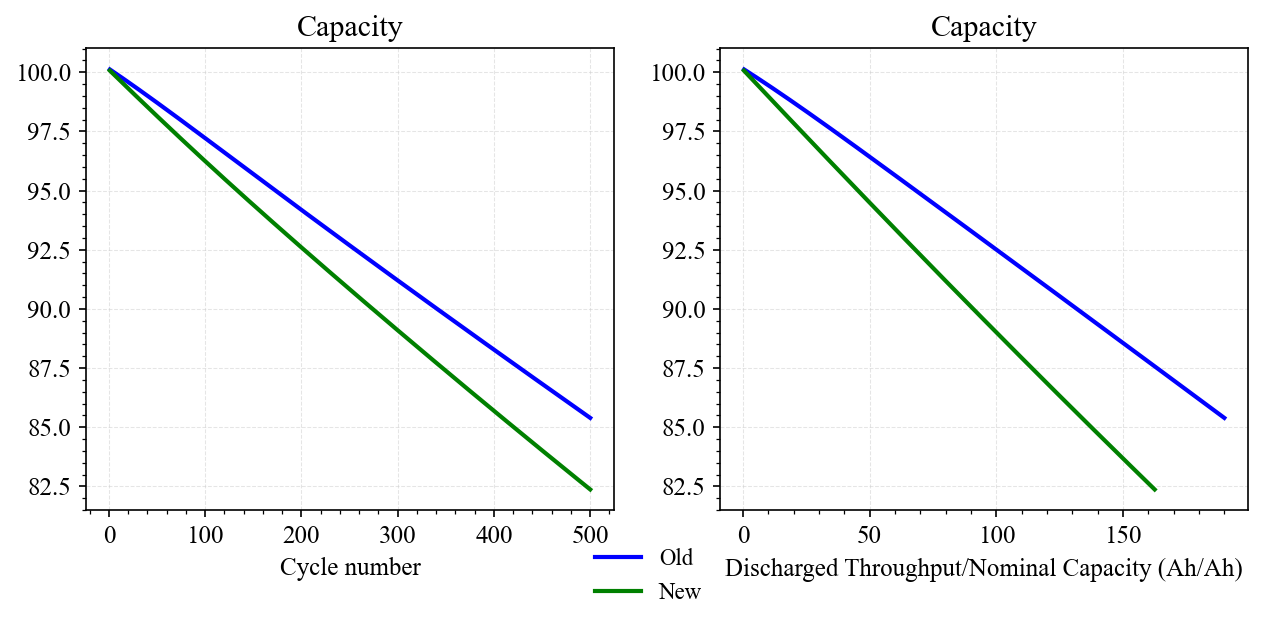

In [51]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[1]
ax.plot(sol_long_peyman_ResytOnly.summary_variables["Throughput capacity [A.h]"]/10,sol_long_peyman_ResytOnly.summary_variables["Capacity [A.h]"]/5.063*100,"b")
ax.plot(sol_long_Andrew_RestOnly.summary_variables["Throughput capacity [A.h]"]/5,sol_long_Andrew_RestOnly.summary_variables["Capacity [A.h]"]/2.4658*100,"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Discharged Throughput/Nominal Capacity (Ah/Ah)")
# ax.grid()

ax = axes.flat[0]
ax.plot(sol_long_peyman_ResytOnly.summary_variables["Cycle number"],sol_long_peyman_ResytOnly.summary_variables["Capacity [A.h]"]/5.063*100,"b")
ax.plot(sol_long_Andrew_RestOnly.summary_variables["Cycle number"],sol_long_Andrew_RestOnly.summary_variables["Capacity [A.h]"]/2.4658*100,"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Cycle number")



fig.legend(["Old"] + ["New"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.08], ncol=1, fontsize=11)


Text(0.5, 1.0, 'Calndar aging at two levels')

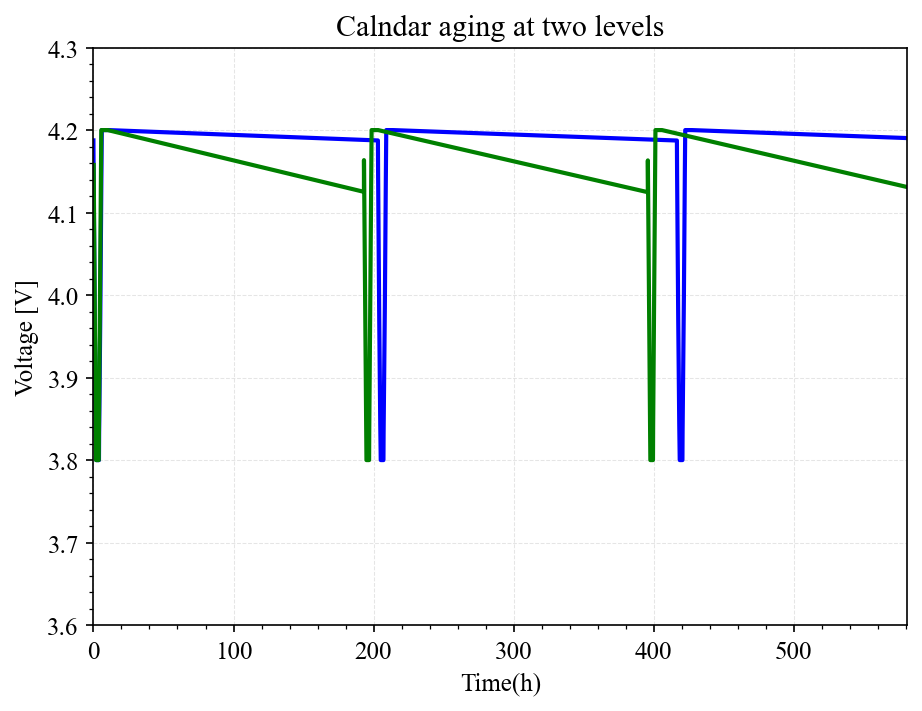

In [55]:
t_And_rs = sol_long_Andrew_RestOnly['Time [h]'].entries
Vt_And_rs= sol_long_Andrew_RestOnly["Terminal voltage [V]"].entries
t_Pey_rs = sol_long_peyman_ResytOnly['Time [h]'].entries
Vt_Pey_rs = sol_long_peyman_ResytOnly["Terminal voltage [V]"].entries

fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t_Pey_rs,Vt_Pey_rs,'b')
ax.plot(t_And_rs+0.2,Vt_And_rs,'g')


# ax.legend(["Peyman"] + ["Andrew"], 
#        loc="lower center",bbox_to_anchor=[0.5,-0.20], ncol=1, fontsize=11)
ax.set_xlabel("Time(h)")

ax.set_ylabel("Voltage [V]")
ax.set_xlim(0,580.8)
ax.set_ylim(3.6,4.3)
ax.set_title("Calndar aging at two levels")